# imports

In [1]:
import thunderfish.dataloader as dl
import thunderfish.pulsetracker as pt
import thunderfish.eventdetection as ed
import matplotlib.pyplot as plt
import numpy as np
import os

# parameters and functions


In [2]:
def plot_peaks(x,y,peaksx,peaksy,c='k'):
    plt.figure(figsize=(10,5))
    plt.plot(x,y,zorder=-1)
    plt.scatter(starttime + peaksx/data.samplerate,peaksy,c=c)
    plt.xlabel('time [s]')
    plt.ylabel('signal')
    
def plot_events_on_data(peaks, data):
    
    """
        plots the detected events onto the data timeseries. If the events are classified, the classes are plotted in different colors and the class -1 (not belonging to a cluster) is plotted in black
    """
    plt.plot(range(len(data)),data, color = 'black')
    if len(peaks)>3:
        classlist =  np.array(peaks[3],dtype=np.int)
        if len(peaks) > 4:
            classlist = np.array(peaks[4],dtype=np.int)
        cmap = plt.get_cmap('jet')
        colors =cmap(np.linspace(0, 1.0, 3000)) #len(np.unique(classlist))))
        np.random.seed(3)
        np.random.shuffle(colors)
        colors = [colors[cl] for cl in np.unique(classlist)]
        for cl, color in zip(np.unique(classlist), colors):
            if min(classlist) == 0 and cl == 0:
                color = 'black'
            if cl == -1:
                color = 'black'
            
            peaksofclass = peaks[:,classlist == cl]
            plt.plot(peaksofclass[0],peaksofclass[1], '.', color = color,   ms =20, label=cl)
    else:
        plt.scatter(peaks[0],peaks[1], color = 'red')
    #plt.legend()

# load data

In [3]:
# create list of filepaths..
text_file = open("leticia_filenames_sorted.txt", "r")
lines = text_file.read().split('\n')
i = 12

In [4]:
filepath = '/home/dexter/' + lines[i][:-4] + '/' + lines[i]

In [5]:
filepath

'/home/dexter/50926L08F13/50926L08F13.WAV'

In [6]:
starttime = 0
endtime = 0.3 #in seconds

with dl.open_data(filepath, -1, 1.0) as data:
    dt = 1/data.samplerate
    # do something with the content of the file:
    x = np.arange(starttime,endtime,dt)
    y = data[starttime*data.samplerate:endtime*data.samplerate,0]

# online clustering step by step
## 1. EOD detection
Create a data structures with the locations and amplitudes of the EODs

In [7]:
from scipy.interpolate import interp1d
from scipy.signal import correlate
from scipy.signal import argrelextrema

# parameters for the analysis
thresh = 0.4 # minimal threshold for peakdetection
peakwidth = 20 # width of a peak and minimal distance between two EODs

In [8]:
pk, tr = ed.detect_peaks(y, thresh)
peaks = pt.makeeventlist(pk,tr,y,peakwidth)
peakindices, peakx, peakh = pt.discardnearbyevents(peaks[0],peaks[1],peakwidth)
peaks = np.transpose(peaks[:,peakindices])

## 2. Online clustering
create object

In [9]:
class cluster_object(object):
    
    def __init__(self,label,mean,peaknum,featnum,track_lenght):
        self.label = label
        self.mean = mean
        self.track_length = track_length
        
        # this should be a numpy array with at least 100 peaks?
        self.features = np.zeros((track_length,featnum))
        
        self.idxs = np.zeros(peaknum)
        self.y = np.zeros(peaknum)
        
        self.peak_count = 0
    
    def update(self,x,y,features):
        
        self.idxs[self.peak_count] = x
        self.y[self.peak_count] = y
        self.features[int(self.peak_count%track_length)] = features
        
        self.peak_count = self.peak_count + 1
        
    def predict_next_idx(self):
        return np.max(self.idxs) + self.get_isi()
    
    def get_isi(self):
        return np.mean(np.diff(self.idxs[self.peak_count-4:self.peak_count]))

def merge_clusters(cluster1,cluster2,track_length):
    
    merged_cluster = cluster_object(cluster1.label,cluster1.mean,len(cluster1.y),cluster1.features.shape[1],cluster1.features.shape[0])
    
    merged_idx = np.append(cluster1.idxs[np.nonzero(cluster1.idxs)],cluster2.idxs[np.nonzero(cluster2.idxs)])
    merged_y = np.append(cluster1.y[np.nonzero(cluster1.y)],cluster2.y[np.nonzero(cluster2.y)])
    
    merged_cluster.idxs[:len(merged_idx)] = merged_idx
    merged_cluster.y[:len(merged_y)] = merged_y

    cur_idx = cluster1.peak_count % track_length
    last_half = range(cur_idx-int(track_length/2), cur_idx)
    
    # take last 50 features of cluster1
    for i in range(cluster1.features.shape[1]):
        merged_cluster.features[:int(track_length/2),i] = cluster1.features[:,i].take(last_half, mode='wrap')
        merged_cluster.features[int(track_length/2):,i] = cluster2.features[:,i].take(last_half, mode='wrap')
    
    merged_cluster.peak_count = len(merged_y)
    
    return merged_cluster

In [10]:
def align(eod,cluster_mean,width):
    
    # don't just take max but take a peak of the cc
    # this is to prevent shifting to the next peak in the sequence.
    
    cc = correlate(eod,cluster_mean,'same')
    plt.plot(cc)
    plt.show()
    local_max_idx = argrelextrema(cc[width:-width], np.greater)[0] + width
    diff = np.abs(local_max_idx - len(eod)/2)
    
    if diff.size > 0:
        offset = local_max_idx[np.argmin(diff)]
    else:
        offset = int(len(eod)/2)
    return extract(eod,offset,width)
    
def extract(eod,offset,width):
    return eod[offset-width:offset+width]

def normalize(x):
    #return x - np.min(x)
    return (((x-np.min(x))/(np.max(x)-np.min(x))) - 0.5)*2

def gen_cheb(n,x):
    return(np.cos(n*np.arccos(x)))

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k/ncol, k%ncol

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, 3000)) #len(np.unique(classlist))))
np.random.seed(4)
np.random.shuffle(colors)

In [11]:
%matplotlib inline

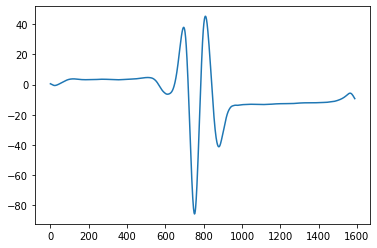

/home/liz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/liz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


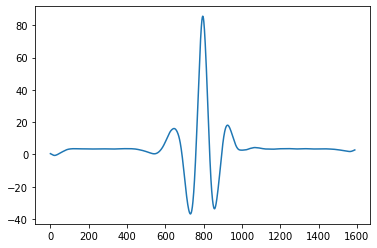

/home/liz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in less


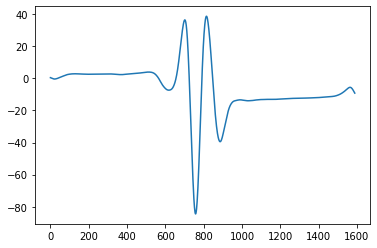

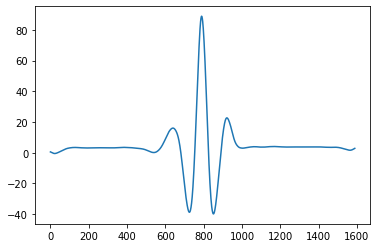

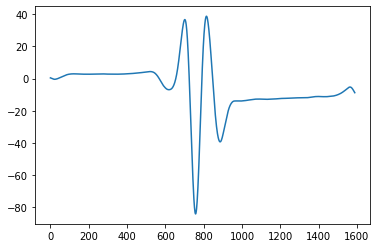

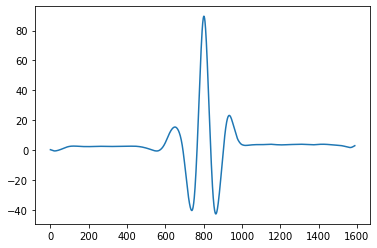

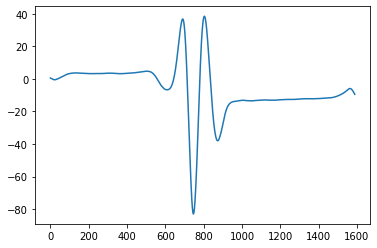

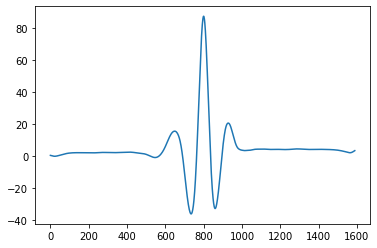

In [12]:
clusters = []
deleted_clusters = []

maxlabel = 1

# parameters
cutwidth = peakwidth*4
alignwidth = 150
int_met = 'quadratic'
error_threshold = 0.05 #different thresholds are needed for different problems
merge_threshold = 0.05
npol = 15
nfeat = 7

track_length = 100

#decide on the plotting
plot_steps = False
plot_means = False
plot_one_peak_step = False

if plot_means == True:
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i,p in enumerate(peaks):
    
    if plot_steps == True:
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
        #f, ax1 = plt.subplots(1, 1,figsize=(5,5))
        ax1.axis("off")
        ax2.axis("off")
    
    # cut along peak to get the EOD shape
    p_idx = int(p[0])
    p_hight = p[2]
    p_y = p[1]
    
    eod = y[p_idx-cutwidth:p_idx+cutwidth]
    
    #interpolate --> needed to properly align peaks
    eod_func = interp1d(range(len(eod)), eod, int_met)
    eod_ip = eod_func(np.arange(0,len(eod)-1,0.1))
    
    # align peaks with ALL CLUSTERS
    if len(clusters) > 0:
        
        current_clusters = []
        
        # I only want to use recent clusters, 
        # but somehow I also need to save all clusters for later
        for c, cluster in enumerate(clusters):
            # delete clusters that are too far away
            if p_idx - np.max(cluster.idxs) < 2000000: #and np.count_nonzero(labels == cluster.label) < 3:
                current_clusters.append(cluster)
            else:
                deleted_clusters.append(cluster)
                
        clusters = current_clusters
 
        c_feats = np.zeros((len(clusters),track_length,nfeat))
        
        # ============== start analysis =================
        for c,cluster in enumerate(clusters):
            c_feats[c] = cluster.features
            
            if plot_steps == True:
                ax1.plot(cluster.mean,c=colors[int(cluster.label)],label='fish %i'%cluster.label,linewidth=3.0)
                ax1.title.set_text('Normalized EODs')
                ax2.plot(cluster.features[0],c=colors[int(cluster.label)],label='fish %i'%cluster.label,linewidth=3.0)
                ax2.title.set_text('Features')
        aligned_eod = align(eod_ip, align_peak, alignwidth)
        
        # normalize
        mean = normalize(aligned_eod)
        
        # extract features
        cheb = np.polynomial.chebyshev.Chebyshev.fit(np.linspace(-1,1,
            len(mean)), mean, npol)
        
        # append peak hight to features
        features = np.append(cheb.coef[:nfeat-1], p_hight/2)
        
        # compute difference in feature vectors
        cluster_errors = np.linalg.norm(c_feats - features, axis=2)

        # take min for each cluster
        cluster_errors = np.min(cluster_errors, axis=1)

        if plot_steps == True:
            ax1.plot(mean,c='k')
            ax2.plot(features,c='k')
            ax2.title.set_text('Features')
        
        if np.min(cluster_errors) < error_threshold:
            # check if two clusters can be merged
            merge_idx = np.where(cluster_errors < merge_threshold)[0]
            if len(merge_idx) > 1:
                # merge clusters
                cluster_merged = merge_clusters(clusters[merge_idx[0]],
                                                clusters[merge_idx[1]],
                                               track_length)
                # delete old clusters
                clusters.pop(merge_idx[1])
                clusters.pop(merge_idx[0])
                cluster_merged.update(p_idx,p_y,features)
                clusters.append(cluster_merged)
            else:
                closest_cluster = cluster_errors.argmin()
                clusters[closest_cluster].update(p_idx,p_y,features)
            # assign eod to the class with the lowest cluster_error

        else:
            # check for collisions
            # check out predicted next peak for all clusters
            # if this predicted peak is in the current area
            # for 2 or more cluster, assign this peak to all
            # of those cluster.
            
            idx_pred = np.zeros(len(clusters))
            
            for c,cluster in enumerate(clusters):
                idx_pred[c] = cluster.predict_next_idx()
                
            pred_error = np.abs(idx_pred - p_idx)
            
            if np.count_nonzero(pred_error<peakwidth*4) >= 2:
                # assign this peak to both clusters but do not update features
                for j in np.nonzero(pred_error<peakwidth*4)[0]:
                    clusters[j].update(p_idx,p_y,np.zeros(nfeat))
                    
            else:    
                new_cluster = cluster_object(maxlabel,mean,len(peaks),nfeat,track_length)
                if plot_means == True:
                    ax1.plot(mean,c=colors[int(maxlabel)])
                    ax2.plot(features,c=colors[int(maxlabel)])
                
                maxlabel = maxlabel + 1
                
                new_cluster.update(p_idx,p_y,features)

                clusters.append(new_cluster)

    else:
        # create new cluster class
        
        # take middle of snip
        mid = int(len(eod_ip)/2)
        eod_ip = extract(eod_ip,mid,alignwidth)
        
        # normalize
        eod_ip = normalize(eod_ip)
        
        # set this as the standard peak for alignment
        align_peak = eod_ip
        
        # extract features
        cheb = np.polynomial.chebyshev.chebfit(np.linspace(-1,1,
            len(eod_ip)), eod_ip, npol)
        
        #features = cheb.coef
        features = np.append(cheb[:nfeat-1], p_hight/2)
        
        new_cluster = cluster_object(maxlabel,eod_ip,len(peaks),nfeat,track_length)
        new_cluster.update(p_idx, p_y, features)
        maxlabel = maxlabel + 1
        
        clusters.append(new_cluster)
    
    # save eods every n steps. before saving delete the short classes.
    # save the peaks of the current buffered part to a numpy-memmap on the disk
    # ==> sth like this: save_EOD_events_to_npmmp(thisblock_eods,eods_len,idx==startblock,datasavepath,mmpname)

In [13]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, 200)) #len(np.unique(classlist))))
np.random.seed(4)
np.random.shuffle(colors)

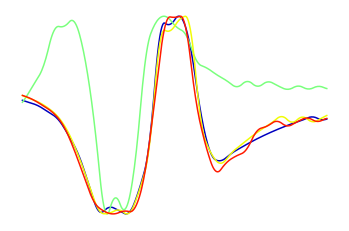

In [14]:
h = 0
plt.axis("off")
for i,c in enumerate(clusters):
    #if np.count_nonzero(c.idxs) > 10:
        plt.plot(c.mean,c=colors[h])
        h = h + 1

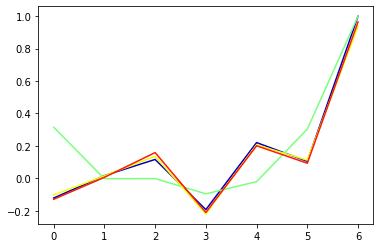

In [15]:
for i,c in enumerate(clusters):
    #if np.count_nonzero(c.idxs) > 10:
        plt.plot(np.transpose(c.features[0]),c=colors[i])

In [16]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, 5)) #len(np.unique(classlist))))
np.random.seed(4)
np.random.shuffle(colors)

In [17]:
%matplotlib qt
plt.plot(y,c='k',alpha=0.3)
h = 0
for l,cluster in enumerate(clusters):
    cx = cluster.idxs[np.nonzero(cluster.idxs)]
    cy = cluster.y[np.nonzero(cluster.y)]
    if len(cx) > 10:
        plt.plot(cx,cy,'.',c=colors[int(h)],alpha=0.5,ms=20,label=cluster.label)
        h = h + 1
#for cluster in deleted_clusters:
#    cx = cluster.idxs[np.nonzero(cluster.idxs)]
#    cy = cluster.y[np.nonzero(cluster.y)]
#    if len(cx) > 10:
#        plt.plot(cx,cy,'.',alpha=0.5,ms=20,label=cluster.label)

In [18]:
len(clusters)

4

In [19]:
print(peaks[0])

[919.           0.99996948   1.99996948]


In [20]:
len(clusters)

4